<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Исходные данные

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу.

Задача: 

разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

оценить качество алгоритма по метрике accuracy@5

*деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.


Data load and exploratory analysis

In [1]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler


Загрузить данные и проверить на:
- явные дубликаты
- выбросы
- пропуски

In [2]:
try:
    df_base = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/base.csv", index_col=0)
except:
    df_base = pd.read_csv('base.csv', index_col=0)


In [3]:
display(df_base.head())

print(df_base.info())

print(df_base.shape)
    
dupl = df_base.duplicated().sum()
print(dupl)
if dupl > 0:
    df_base.drop_duplicates(inplace=True)

# fig, axs = plt.subplots(figsize=(3, 3))

# for x in ['0', '1', '2', '3', '4', '5','6', '7', '8', '9', '10']:
#     print(x)
#     sns.histplot(data=df_base, x=x, kde=True)
#     plt.show()
    
    

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [4]:
df_base.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
4744755-base,-125.08630,4.735448,38.284935,-125.27671,209.788360,-47.870010,-628.127378,-71.077340,125.534355,29.34185,...,-70.364395,55.428260,-191.53702,122.978279,65.515260,108.963715,-52.795380,117.254510,-615.998268,-77.768555
4744759-base,-108.59839,5.454173,-22.191975,-158.71666,113.606110,-88.843430,-117.234538,137.317690,129.056690,164.75424,...,-70.360190,18.439003,-90.65145,-28.586794,68.691666,1.636499,-24.388298,93.530540,-1074.464888,-90.800400
4744762-base,-97.02673,-2.143885,-71.274090,-144.68066,149.464810,-21.572212,-759.626065,-108.151955,124.810135,118.76070,...,-55.961933,62.923470,-169.11832,108.452806,68.592970,43.205433,69.029830,129.536650,-1074.464888,4.718300
4744763-base,-86.83843,8.911945,-34.837738,-106.46268,42.236572,-96.194230,-532.907338,9.845185,126.037560,59.22310,...,-86.867020,-6.959065,-174.07591,-151.007973,68.622246,0.707927,94.451866,124.843000,-1074.464888,-55.789314
4744766-base,-101.96527,12.859500,-51.393135,-168.21826,101.065110,-71.914600,34.734278,-5.394417,135.523760,125.36194,...,-67.404680,72.963425,-147.85870,-5.081259,69.688720,-20.186157,84.479110,92.833786,-1073.826170,14.774761


In [5]:
df_base.dropna(axis=0,inplace=True)

df_base.fillna(0,inplace=True)

In [6]:
df_base.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

In [7]:
df_base_non_normal = ['70','65','59','44','33','25','21','6']
df_base_normal = ['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26', '27', '28', '29', '30', '31', '32' 
        , '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '60',
       '61', '62', '63','64', '66', '67', '68', '69', '71']

In [8]:
df_base.drop(columns=df_base_non_normal,inplace=True)

In [9]:
try:
    df_train = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/train.csv", index_col=0)
except:
    df_train = pd.read_csv("train.csv", index_col=0)


In [10]:
display(df_train.head())    

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [11]:
df_train.drop(columns=df_base_non_normal,inplace=True)

In [12]:
try:
    df_valid = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/validation.csv", index_col=0)
except:
    df_valid = pd.read_csv("validation.csv", index_col=0)

df_valid.head()

df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

In [13]:
df_valid.drop(columns=df_base_non_normal,inplace=True)

In [14]:
# df_train_nn = pd.DataFrame(data = df_train[df_base_non_normal],index=df_train.index)
# df_base_nn = pd.DataFrame(data = df_base[df_base_non_normal],index=df_base.index)
# df_valid_nn = pd.DataFrame(data = df_valid[df_base_non_normal],index=df_valid.index)

# df_compare_non_normal = pd.concat([df_base_nn,df_train_nn,df_valid_nn],axis=1)

# for x in df_base_non_normal:

#     fig, axs = plt.subplots(figsize=(5, 5))
#     sns.histplot(data=df_base_nn, x=x, kde=True).set(title='df_base')
    
#     fig, axs = plt.subplots(figsize=(5, 5))
#     sns.histplot(data=df_train_nn, x=x, kde=True).set(title='df_train')
    
#     fig, axs = plt.subplots(figsize=(5, 5))
#     sns.histplot(data=df_valid_nn, x=x, kde=True).set(title='df_valid')
   
#     plt.show()

In [15]:
st_scaler = StandardScaler()

#mm_scaler = MinMaxScaler()


st_scaler.fit(df_base[df_base_normal])
#mm_scaler.fit(df_base[df_base_non_normal])

df_base_st_scaled = pd.DataFrame(data=st_scaler.transform(df_base[df_base_normal]),
                                index=df_base.index,
                                columns=df_base_normal)

# df_base_mm_scaled = pd.DataFrame(data=mm_scaler.transform(df_base[df_base_non_normal]),
#                                 index=df_base.index,
#                                 columns=df_base_non_normal)

df_base_scaled = df_base_st_scaled.copy() #pd.concat([df_base_st_scaled,df_base_mm_scaled],axis=1)

#display(df_base_scaled)

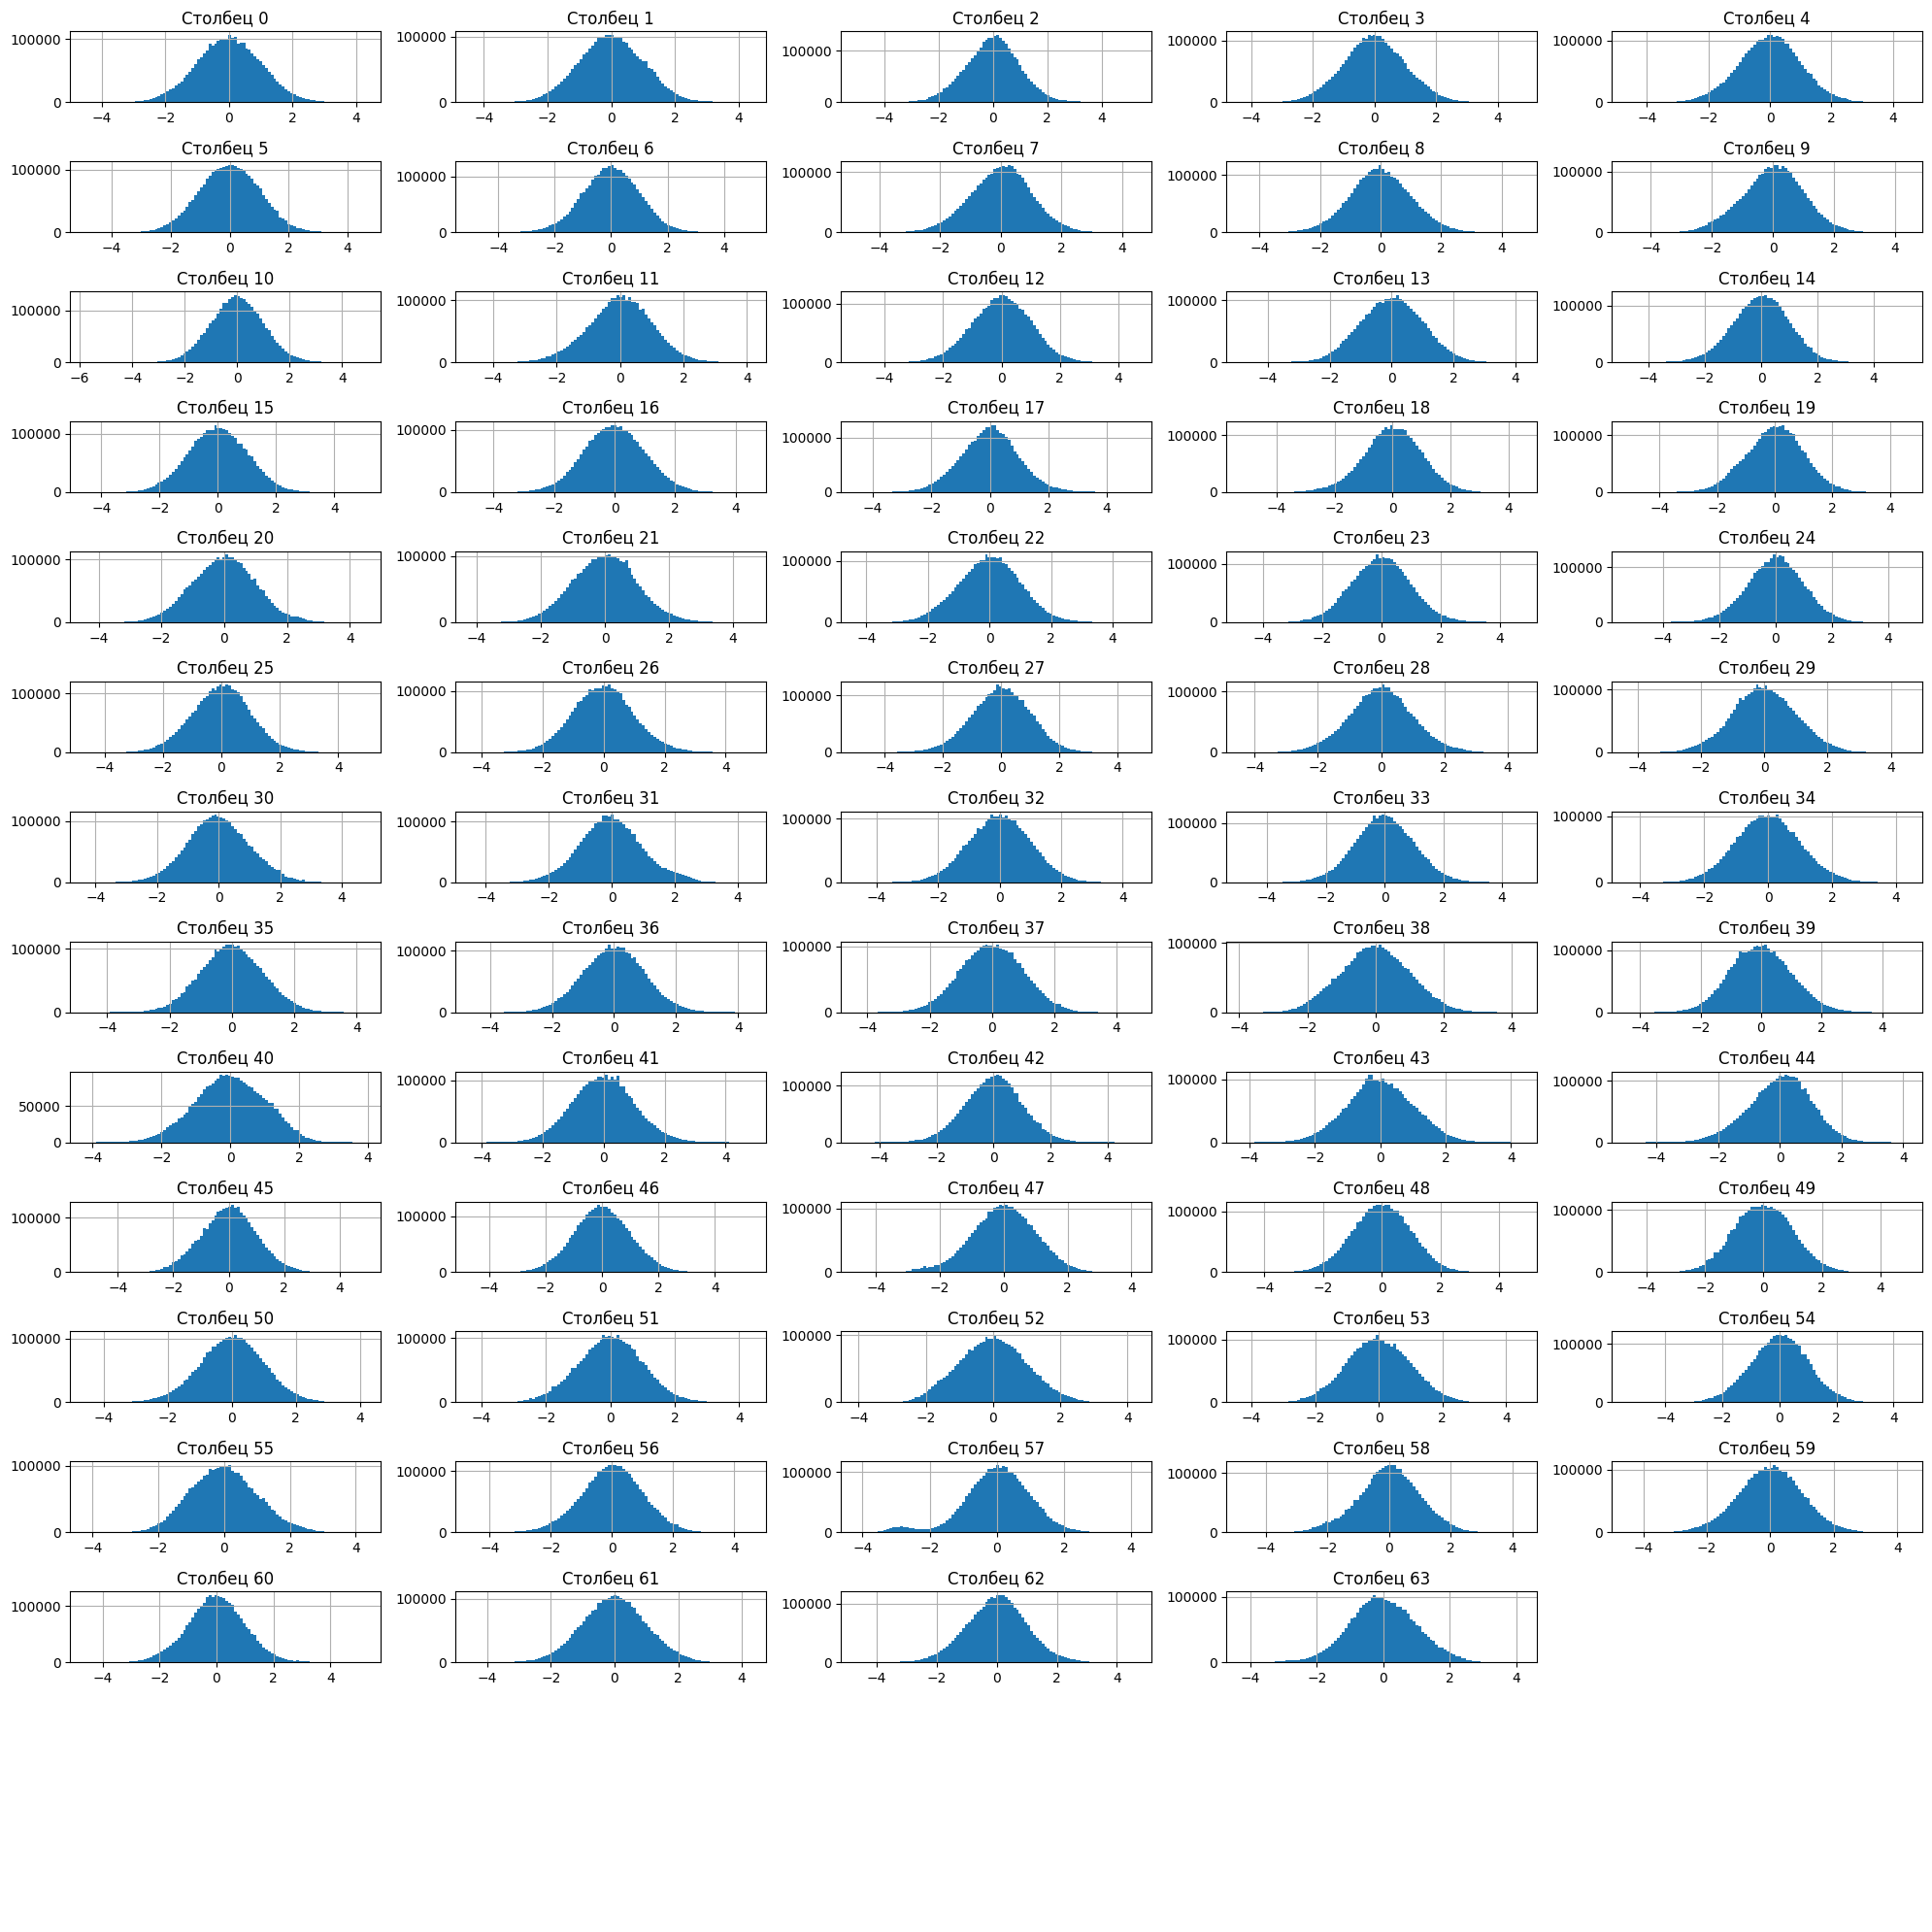

In [16]:
num_columns = df_base_scaled.shape[1]
num_rows = 15
num_cols = 5 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < num_columns:
        df_base_scaled.iloc[:, i].hist(bins=100, ax=ax)
        ax.set_title(f'Столбец {i}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
display(df_base_scaled.describe())

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.980042e-16,-5.434979e-16,7.589211e-16,6.735381e-15,-1.237639e-15,8.142899e-16,1.729522e-16,-2.945636e-15,1.349276e-15,-1.930612e-15,...,5.201957e-17,2.243153e-15,-2.531907e-15,-1.161261e-16,-1.269087e-15,2.163717e-14,2.445826e-16,2.514929e-16,-2.798335e-15,-3.733337e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.549347e+00,-4.440333e+00,-5.060425e+00,-4.335249e+00,-4.679796e+00,-4.932126e+00,-5.017608e+00,-4.803440e+00,-4.630256e+00,-4.814505e+00,...,-5.375082e+00,-4.251340e+00,-4.647408e+00,-4.216748e+00,-4.829253e+00,-4.542299e+00,-4.638105e+00,-4.540891e+00,-4.715060e+00,-4.287361e+00
25%,-6.763790e-01,-6.806629e-01,-6.465860e-01,-6.686925e-01,-6.647240e-01,-6.878777e-01,-6.629821e-01,-6.608211e-01,-6.625822e-01,-6.519466e-01,...,-6.659353e-01,-7.024033e-01,-6.481733e-01,-5.645887e-01,-6.302236e-01,-6.640009e-01,-6.516026e-01,-6.713435e-01,-6.554866e-01,-6.677003e-01
50%,-8.141161e-05,-8.302823e-03,1.978169e-02,-7.146414e-03,1.200420e-02,2.450716e-03,7.037827e-03,3.272698e-02,-1.490530e-02,3.416003e-02,...,2.006878e-02,-2.173047e-02,1.755754e-02,4.907813e-02,1.986265e-02,1.256494e-02,-2.320152e-03,-4.781398e-04,2.161630e-02,-1.917957e-02
75%,6.818803e-01,6.843780e-01,6.459868e-01,6.705704e-01,6.700956e-01,6.936148e-01,6.784155e-01,6.743507e-01,6.636998e-01,6.753471e-01,...,6.787547e-01,6.689057e-01,6.727419e-01,6.531511e-01,6.659273e-01,6.773202e-01,6.542963e-01,6.669939e-01,6.604742e-01,6.725351e-01
max,4.328619e+00,4.412564e+00,5.319939e+00,4.800260e+00,4.495286e+00,4.640507e+00,4.996785e+00,4.495985e+00,4.704041e+00,4.426955e+00,...,4.516514e+00,4.329656e+00,4.570366e+00,4.184390e+00,4.345387e+00,4.343838e+00,5.264585e+00,4.313548e+00,4.681879e+00,4.186175e+00


In [18]:
df_train_st_scaled = pd.DataFrame(data=st_scaler.transform(df_train[df_base_normal]),
                                index=df_train.index,
                                columns=df_base_normal)

#df_train_mm_scaled = pd.DataFrame(data=mm_scaler.transform(df_train[df_base_non_normal]),
#                                 index=df_train.index,
#                                 columns=df_base_non_normal)

df_train_scaled = df_train_st_scaled.copy() #pd.concat([df_train_st_scaled,df_train_mm_scaled],axis=1)

display(df_train_scaled)

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,-0.193435,-0.179583,-0.866975,1.274319,-0.024410,-1.035388,0.197184,-0.200786,0.906575,0.522963
1-query,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,-1.538329,0.193777,0.246358,-0.826778,...,1.382837,-0.704733,1.254600,-0.991073,0.075152,0.207972,0.028031,0.244774,0.709459,-0.083491
2-query,1.456328,-0.855696,-1.851792,-1.701553,1.700433,0.750504,-0.791080,0.328335,1.352615,1.362356,...,-0.126222,-0.894063,0.886224,1.548929,-0.348054,-0.978114,-0.092956,2.240614,0.300576,0.604677
3-query,1.543467,0.203199,-1.833235,1.291201,-0.359536,-1.322073,0.916179,0.050167,1.834418,-0.081019,...,-1.416759,-0.055445,0.573141,0.388351,0.227494,-2.007464,1.491032,0.133987,0.128028,0.668019
4-query,0.265046,1.284537,-0.370748,-0.021041,-1.169187,1.977993,0.399148,0.355099,-0.326947,0.863249,...,-1.005156,2.855665,0.336621,0.406133,-1.001615,-0.474647,0.341715,0.043401,-1.090276,0.638160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995-query,0.725110,0.722221,-0.481442,-2.121036,0.427126,0.243597,1.177860,-0.774538,-2.019131,0.519870,...,0.230771,-0.974202,0.840573,0.182656,0.526545,-0.720830,-1.078627,-0.216310,-0.402772,0.303320
99996-query,0.790982,-1.186858,-0.665550,0.023540,-0.722780,0.868008,-0.709106,1.229618,0.912654,1.640729,...,-1.583831,1.045946,-1.169178,0.000956,1.072533,-1.082383,-0.972380,0.958916,1.838433,-1.458088
99997-query,1.296887,-0.676949,0.396096,-0.027606,3.296232,-1.033995,0.742875,-0.881030,1.055263,-1.555459,...,-1.233269,-1.716243,0.137449,-1.642466,-0.724428,-0.243436,1.570089,-0.638580,-0.186539,1.042461


In [19]:
df_valid_st_scaled = pd.DataFrame(data=st_scaler.transform(df_valid[df_base_normal]),
                                index=df_valid.index,
                                columns=df_base_normal)

# df_valid_mm_scaled = pd.DataFrame(data=mm_scaler.transform(df_valid[df_base_non_normal]),
#                                 index=df_valid.index,
#                                 columns=df_base_non_normal)

df_valid_scaled = df_valid_st_scaled.copy() #pd.concat([df_valid_st_scaled,df_valid_mm_scaled],axis=1)

display(df_valid_scaled)

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.767701,-1.413223,0.115241,0.676228,0.275453,0.817488,0.693550,0.597167,-0.020121,-1.659674
100001-query,1.304502,0.950910,0.033969,0.615646,0.067603,-0.657373,0.679613,0.540216,-1.107069,-0.253738,...,-0.548876,-1.135690,-0.013756,-0.142350,-0.334949,1.631021,-1.617587,0.360549,0.369533,0.545701
100002-query,0.886027,-2.434901,0.955216,-1.185496,-0.320843,0.341078,1.045290,1.193478,0.690080,-1.851159,...,1.127774,0.402836,-1.831225,0.140946,-0.118026,-0.044550,1.128563,1.021715,1.204944,-0.555197
100003-query,-0.524576,1.623911,1.408637,-0.071830,-0.595916,-2.190385,-0.613543,-1.359610,-0.764409,0.692479,...,0.783558,0.268198,0.058666,0.373992,0.540055,1.695934,0.000596,0.949135,1.307485,-0.996489
100004-query,0.269032,-1.704743,0.739119,-1.221980,1.168059,1.550401,0.218922,0.821217,-0.347213,1.605413,...,0.856405,-0.512342,-1.469227,0.427148,0.498123,1.549868,-0.148400,1.297723,-0.654827,-1.856774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995-query,1.589176,-0.289879,1.344941,1.537359,-0.674999,0.842355,1.367212,-0.150169,-0.323048,-0.841683,...,0.120487,-1.653497,0.439374,1.022174,0.143790,-0.437841,0.957303,-0.137479,-0.155512,-0.838686
199996-query,-0.343768,0.559732,1.508635,1.058998,-1.936880,-0.625634,-1.041262,-0.016599,-0.782626,-0.262283,...,-0.128583,0.524576,0.459344,0.163484,0.998530,-1.990528,-2.540145,0.310819,-1.383091,-0.376062
199997-query,1.084917,1.111515,1.740436,0.590027,0.731186,0.309134,-0.063464,0.702601,0.688763,0.005729,...,-0.152754,1.591220,0.991457,0.220952,0.132423,2.066273,0.030580,-1.808538,-0.833142,0.472120


In [20]:
try:
    df_valid_answer = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/validation_answer.csv", index_col=0)
except:
    df_valid_answer = pd.read_csv("validation_answer.csv", index_col=0)

df_valid_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


Baseline

Create index

In [21]:
df_base_scaled.columns

Index(['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26', '27',
       '28', '29', '30', '31', '32', '34', '35', '36', '37', '38', '39', '40',
       '41', '42', '43', '45', '46', '47', '48', '49', '50', '51', '52', '53',
       '54', '55', '56', '57', '58', '60', '61', '62', '63', '64', '66', '67',
       '68', '69', '71'],
      dtype='object')

In [22]:
df_base_scaled.describe()

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.980042e-16,-5.434979e-16,7.589211e-16,6.735381e-15,-1.237639e-15,8.142899e-16,1.729522e-16,-2.945636e-15,1.349276e-15,-1.930612e-15,...,5.201957e-17,2.243153e-15,-2.531907e-15,-1.161261e-16,-1.269087e-15,2.163717e-14,2.445826e-16,2.514929e-16,-2.798335e-15,-3.733337e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.549347e+00,-4.440333e+00,-5.060425e+00,-4.335249e+00,-4.679796e+00,-4.932126e+00,-5.017608e+00,-4.803440e+00,-4.630256e+00,-4.814505e+00,...,-5.375082e+00,-4.251340e+00,-4.647408e+00,-4.216748e+00,-4.829253e+00,-4.542299e+00,-4.638105e+00,-4.540891e+00,-4.715060e+00,-4.287361e+00
25%,-6.763790e-01,-6.806629e-01,-6.465860e-01,-6.686925e-01,-6.647240e-01,-6.878777e-01,-6.629821e-01,-6.608211e-01,-6.625822e-01,-6.519466e-01,...,-6.659353e-01,-7.024033e-01,-6.481733e-01,-5.645887e-01,-6.302236e-01,-6.640009e-01,-6.516026e-01,-6.713435e-01,-6.554866e-01,-6.677003e-01
50%,-8.141161e-05,-8.302823e-03,1.978169e-02,-7.146414e-03,1.200420e-02,2.450716e-03,7.037827e-03,3.272698e-02,-1.490530e-02,3.416003e-02,...,2.006878e-02,-2.173047e-02,1.755754e-02,4.907813e-02,1.986265e-02,1.256494e-02,-2.320152e-03,-4.781398e-04,2.161630e-02,-1.917957e-02
75%,6.818803e-01,6.843780e-01,6.459868e-01,6.705704e-01,6.700956e-01,6.936148e-01,6.784155e-01,6.743507e-01,6.636998e-01,6.753471e-01,...,6.787547e-01,6.689057e-01,6.727419e-01,6.531511e-01,6.659273e-01,6.773202e-01,6.542963e-01,6.669939e-01,6.604742e-01,6.725351e-01
max,4.328619e+00,4.412564e+00,5.319939e+00,4.800260e+00,4.495286e+00,4.640507e+00,4.996785e+00,4.495985e+00,4.704041e+00,4.426955e+00,...,4.516514e+00,4.329656e+00,4.570366e+00,4.184390e+00,4.345387e+00,4.343838e+00,5.264585e+00,4.313548e+00,4.681879e+00,4.186175e+00


In [23]:
dims = df_base_scaled.shape[1]
n_cells = 760


quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)



In [24]:
idx_l2.nprobe = 50

In [25]:
idx_l2.train(np.ascontiguousarray(df_base_scaled.values).astype('float32'))

In [26]:
idx_l2.add(np.ascontiguousarray(df_base_scaled.values).astype('float32'))

In [27]:
base_index = {k: v for k, v in enumerate(df_base_scaled.index.to_list())}

#del df_base

Train

In [28]:
targets = df_train["Target"]
#df_train.drop("Target", axis=1, inplace=True)

In [29]:
r, idx = idx_l2.search(np.ascontiguousarray(df_train_scaled.values).astype('float32'), 5)

In [30]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

70.7


matching the valid dataframe

In [31]:
targets = df_valid_answer['Expected']

In [32]:
targets

Id
100000-query    2676668-base
100001-query      91606-base
100002-query     472256-base
100003-query    3168654-base
100004-query      75484-base
                    ...     
199995-query     967418-base
199996-query    1344948-base
199997-query    1690782-base
199998-query     341779-base
199999-query     336472-base
Name: Expected, Length: 100000, dtype: object

In [33]:
idx_l2.nprobe = 50
r, idx = idx_l2.search(np.ascontiguousarray(df_valid_scaled.values).astype('float32'), 5)

In [34]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

70.58
